# Landmark free morphometry paper - Paper figures


## Python Packages required:

- matplotlib

- numpy

- vtk

- pandas



# Data Loading

Thew data is described in the file 

    data.csv

It describes the subject ID, GroupID and Gender for each subject



In [1]:
%matplotlib inline

### General Imports
import os
from glob import glob
import pandas as pd
import numpy as np
import vtk
from matplotlib import pyplot as plt

working_directory = os.path.join(os.getcwd(), 'data', 'figures', 'craniums')

# find the initial data description
df = pd.read_csv (os.path.join(working_directory, 'data.csv'))

#define the groups
g1 = df['GroupId'].values < 0
g2 = df['GroupId'].values > 0

WTf = list(df.loc[(df['GroupId'] < 0) &
                  (df['Gender']  < 0)].index)
WTm = list(df.loc[(df['GroupId'] < 0) &
                  (df['Gender']  > 0)].index)
CRf = list(df.loc[(df['GroupId'] > 0) &
                  (df['Gender']  < 0)].index)
CRm = list(df.loc[(df['GroupId'] > 0) &
                  (df['Gender']  > 0)].index)

df


,id,GroupId,Gender
0,07_5f,1,1
1,08_6a,-1,-1
2,08_6b,-1,-1
3,08_6g,1,1
4,09_4e,1,-1
5,09_4i,-1,1
6,09_4j,-1,1
7,09_4k,1,1
8,09_4l,1,1
9,11_4e,-1,1


# Centroid sizes

The first figure compares centroid sizes calculated with (1) the manually placed landmarks and (2) the landmark free method

In [2]:
### read LMS file
def read_mps_file(landmarksfile):
    """Read MPS file (from [MITK](http://mitk.org/wiki/The_Medical_Imaging_Interaction_Toolkit_(MITK)))
        Converts the XML landmarks into a Numpy array
    """
    ### import XML reader
    import xml.etree.ElementTree as ET
    import numpy as np
    ### read file
    tree = ET.parse(landmarksfile)
    root = tree.getroot()
    ### list elements which tags are 'point'
    point_elements = [elem for elem in root.iter() if (elem is not root) and (elem.tag == 'point')]
    ### feed the numpy array
    lms = np.zeros([len(point_elements), 3])
    for idx, p in enumerate(point_elements):
        lms[idx, 0] = float(p.find('x').text)
        lms[idx, 1] = float(p.find('y').text)
        lms[idx, 2] = float(p.find('z').text)
    return lms

def read_csv_file(landmarkfile):
    import numpy as np
    return np.loadtxt(landmarkfile, delimiter=' ')

def numpy_to_vtk(numpy_array):
    import vtk
    import numpy as np

    group = vtk.vtkMultiBlockDataGroupFilter()
    for dataset in numpy_array:
        pts = vtk.vtkPoints()
        for p in dataset:
            pts.InsertNextPoint(p[0], p[1], p[2])
        poly = vtk.vtkPolyData()
        poly.SetPoints(pts)
        group.AddInputData(poly)
    group.Update()
    return group.GetOutput()

def vtk_to_numpy(vtk_dataset):
    import vtk
    import numpy as np

    datasets = []
    if isinstance(vtk_dataset, vtk.vtkDataSet): 
        datasets.append(vtk_dataset)
        n1 = 1
        n2 = vtk_dataset.GetNumberOfPoints()
    elif isinstance(vtk_dataset, vtk.vtkMultiBlockDataSet):
        n1 = vtk_dataset.GetNumberOfBlocks()
        n2 = vtk_dataset.GetBlock(0).GetNumberOfPoints() if n1 > 0 else 0
        datasets = [vtk_dataset.GetBlock(idx) for idx in range(n1)]
    else:
        raise Exception('input type not recognised: {}'.format(type(vtk_dataset)))
    ret = np.zeros([n1, n2, 3])
    for id1 in range(n1):
        for id2 in range(n2):
            l = datasets[id1].GetPoint(id2)
            ret[id1, id2] = l
    return ret.squeeze()


def centroid_size(pts):
    cp = np.mean(pts, axis=0)
    return np.sqrt(np.sum([np.dot(c-cp,c-cp) for c in pts]) / (len(pts)))

def scale_shape(vtk_points, factor):
    import vtk
    import numpy as np
    newpoints = vtk.vtkPoints()
    for i in range(vtk_points.GetNumberOfPoints()):
        p = vtk_points.GetPoint(i)
        newpoints.InsertNextPoint(p[0]*factor, p[1]*factor, p[2]*factor)
    return newpoints

def execute_procrustes(vtk_group, mode='similarity'):
    import vtk
    import numpy as np

    ### compute the Procrustes from all landmar files
    procrustes = vtk.vtkProcrustesAlignmentFilter()
    procrustes.SetInputData(vtk_group)
    if mode == 'similarity':
        procrustes.GetLandmarkTransform().SetModeToSimilarity()
    elif mode == 'rigid':
        procrustes.GetLandmarkTransform().SetModeToRigidBody()
    elif mode == 'affine':
        procrustes.GetLandmarkTransform().SetModeToAffine()
    procrustes.Update()

    ret_dataset = procrustes.GetOutput()
    ret_mean_points = procrustes.GetMeanPoints()

    if mode == 'similarity':
        S1 = np.array([centroid_size(vtk_to_numpy(vtk_group.GetBlock(idx))) for idx in range(vtk_group.GetNumberOfBlocks())] )
        s1 = np.mean(S1)
        S2 = np.array([centroid_size(vtk_to_numpy(ret_dataset.GetBlock(idx))) for idx in range(ret_dataset.GetNumberOfBlocks())] )
        s2 = np.mean(S2)
        s = s1 / s2
        print('similarity compensation with factor={:.2f}'.format(s))
        ret_mean_points = scale_shape(ret_mean_points, s)
        for idx in range(vtk_group.GetNumberOfBlocks()):
            corrected_points = scale_shape(ret_dataset.GetBlock(idx).GetPoints(), s)
            ret_dataset.GetBlock(idx).SetPoints(corrected_points)
    return ret_dataset, ret_mean_points

def align_landmarks_to_center(landmarksfiles, mode='similarity', filetype='MITK'):
    import numpy as np
    if filetype == 'microview':
        numpy_landmarks = np.array([read_csv_file(l) for l in landmarksfiles])
    elif filetype == 'MITK':
        numpy_landmarks = np.array([read_mps_file(l) for l in landmarksfiles])
    else:
        raise Exception('unknown filetype: {}'.format(filetype))
    vtk_landmarks_group = numpy_to_vtk(numpy_landmarks)
    procrustes_output, procrustes_mean_points = execute_procrustes(vtk_landmarks_group, mode=mode)
    return procrustes_output

def align_meshes_to_center(meshfiles, landmarksfiles, mode='similarity', write_outputs=False):
    import vtk
    import numpy as np
    import os
    # read input landmarks
    numpy_landmarks = np.array([read_mps_file(l) for l in landmarksfiles])
    vtk_landmarks_group = numpy_to_vtk(numpy_landmarks)
    # execute landmark alignment rigidly (initialisation)
    procrustes_output, procrustes_mean_points = execute_procrustes(vtk_landmarks_group, mode=mode)
    
    # apply the rigid transform to the input meshes
    vtk_mesh_group = vtk.vtkMultiBlockDataGroupFilter()
    for idx, (m, l) in enumerate(zip(meshfiles, landmarksfiles)):
        # read the input mesh
        reader = vtk.vtkPolyDataReader()
        reader.SetFileName(m)
        reader.Update()
        mesh = reader.GetOutput()
        # read the input landmakrs (source)
        lms = read_mps_file(l)
        sourcepoints = vtk.vtkPoints()
        for p in lms:
            sourcepoints.InsertNextPoint(p[0], p[1],p[2])
        # target is the procrustes output
        targetpoints = procrustes_output.GetBlock(idx).GetPoints()
        # transform rigidly the mesh points
        transform = vtk.vtkLandmarkTransform()
        transform.SetSourceLandmarks(sourcepoints)
        transform.SetTargetLandmarks(targetpoints)
        if mode == 'similarity':
            transform.SetModeToSimilarity()
        elif mode == 'rigid':
            transform.SetModeToRigidBody()
        elif mode == 'affine':
            transform.SetModeToAffine()
        transform.Update()
        transformedpoints = vtk.vtkPoints()
        transform.TransformPoints(mesh.GetPoints(), transformedpoints)
        # push the transformed points into the mesh
        mesh.SetPoints(transformedpoints)
        vtk_mesh_group.AddInputData(mesh)
    vtk_mesh_group.Update()
    # vtk_mesh_group is the group of meshes that have been rigidly aligned

    # execute procrustes on vtk_mesh_group according to the input mode
    procrustes_output, procrustes_mean_points = execute_procrustes(vtk_mesh_group.GetOutput(), mode=mode)
    # apply the 'mode' transform to each mesh of vtk_mesh_group
    out_vtk_mesh_group = vtk.vtkMultiBlockDataGroupFilter()
    for idx in range(vtk_mesh_group.GetOutput().GetNumberOfBlocks()):
        # source mesh is the idx of vtk_mesh_group
        mesh = vtk_mesh_group.GetOutput().GetBlock(idx)
        sourcepoints = mesh.GetPoints()
        # target mesh is the procrustes output 
        targetpoints = procrustes_output.GetBlock(idx).GetPoints()
        # transform the points
        transform = vtk.vtkLandmarkTransform()
        transform.SetSourceLandmarks(sourcepoints)
        transform.SetTargetLandmarks(targetpoints)
        if mode == 'similarity':
            transform.SetModeToSimilarity()
        elif mode == 'rigid':
            transform.SetModeToRigidBody()
        elif mode == 'affine':
            transform.SetModeToAffine()
        transform.Update()
        transformedpoints = vtk.vtkPoints()
        transform.TransformPoints(sourcepoints, transformedpoints)
        # push the transformed points into the mesh
        mesh.SetPoints(transformedpoints)
        out_vtk_mesh_group.AddInputData(mesh)
        # write the output mesh if needed
        if write_outputs:
            m = meshfiles[idx]
            odir = os.path.join(os.path.dirname(m), 'outputs')
            if not os.path.exists(odir):
                os.mkdir(odir)
            w = vtk.vtkPolyDataWriter()
            w.SetFileName(os.path.join(odir, os.path.basename(m)))
            w.SetInputData(mesh)
            w.Update()

    out_vtk_mesh_group.Update()
    # vtk_mesh_group is the group of meshes that have been 'mode' aligned
    
    return out_vtk_mesh_group.GetOutput()

## Load meshes and landmarks

Meshes, MITK landmarks and MPS landmarks are assumed to be present in the working directory

In [3]:
### Find meshes and landmark files
mpslandmarksfiles = glob('{}{}*.mps'.format(working_directory, os.sep))
landmarksfiles    = glob('{}{}*.csv'.format(working_directory, os.sep))
meshfiles         = glob('{}{}*.vtk'.format(working_directory, os.sep))

# remove already aligned meshes
meshfiles[:] = [el for el in meshfiles if not (('initial_template.vtk' in el) or ('_r.vtk' in el)) ]
landmarksfiles[:] = [el for el in landmarksfiles if not ('data.csv' in el)]

### assert similar size and sort lists
assert(len(meshfiles) == len(landmarksfiles))
mpslandmarksfiles.sort()
landmarksfiles.sort()
meshfiles.sort()


## Align landmarks and meshes (rigid and similarity)

This is achieved using simple Procrustes algorithm


In [4]:

# # align the landmarks to regress translation (and size)
l_rigid = align_landmarks_to_center(landmarksfiles, filetype='microview', mode='rigid')
l_simil = align_landmarks_to_center(landmarksfiles, filetype='microview', mode='similarity')

m_rigid = align_meshes_to_center(meshfiles, mpslandmarksfiles, mode='rigid', write_outputs=False)
m_simil = align_meshes_to_center(meshfiles, mpslandmarksfiles, mode='similarity', write_outputs=False)


similarity compensation with factor=50.82
similarity compensation with factor=23.21
similarity compensation with factor=1.00


## Centroid size comparison

The centroid sizes are compared.

`#1` refers to method 1 (landmarks based)

`#2` refers to method 2 (landmark-free based)

The shift between methods is explained by the fact that for method 2, we use all points of the mesh to estimate the centroid size, as opposed to the 17 landmarks used in method 1. We can argue that centroid sizes measured using method `#2` are a better approximate of the real size of the object


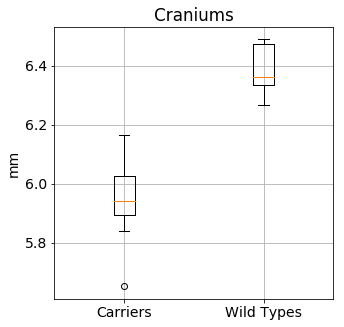

In [5]:
g1 = df.index[df['GroupId'] < 0].tolist()
g2 = df.index[df['GroupId'] > 0].tolist()

centroid_sizes = []
for method in (l_rigid,):
    for groupid in (g2, g1):
        datasets = [method.GetBlock(idx) for idx in groupid]
        centroid_sizes.append([centroid_size(vtk_to_numpy(d)) for d in datasets])

labels = ('Carriers', 'Wild Types') 

font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(1,1,1)
ax.grid(which='major', axis='both')
ax.boxplot(centroid_sizes, labels=labels)
ax.set_title('Craniums')
ax.set_ylabel('mm')
# ax.set_ylim((3,8))
plt.savefig(os.path.join(working_directory, 'centroid-size.pdf'))


## Kernel PCA on landmarks - Rigid

The kernel PCA method evaluates correlations and separation power between groups

We produce kPCA graphs from both **rigid** initialisation and **similarity** initialisation

The Permutation score evaluates the statistical confidence on this separation power.


SVM Classification score 1.00 +/- 0.00)
Classification score 1.00 (pvalue : 0.0020)


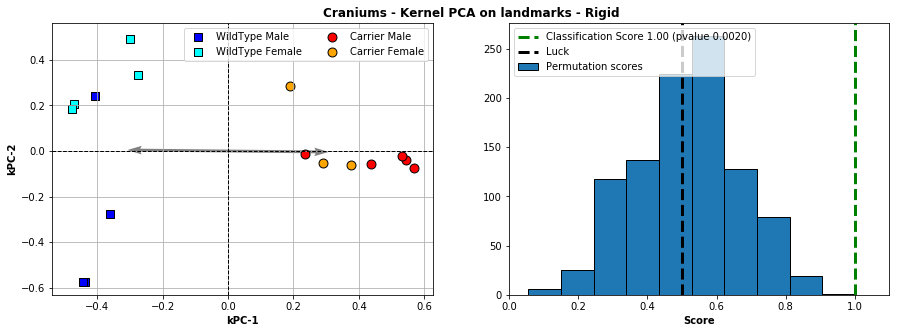

In [6]:
landmarks = l_rigid
landmarks = vtk_to_numpy(landmarks)
landmarks = landmarks.reshape(landmarks.shape[0], -1)

%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1 = fig.add_subplot(121)

idx = [0,1]
n_permutations=1000

pca = PCA(n_components=5)
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=5, gamma=.25)
X_kpca = kpca.fit_transform(landmarks)

for i in range(X_kpca.shape[1]):
    df['PC{}'.format(i+1)] = X_kpca[:, i]

ax1.axhline(linewidth=1, color='k', linestyle= '--')
ax1.axvline(linewidth=1, color='k', linestyle= '--')

# for index, label in enumerate(df['id'].values):
#     plt.text(X_kpca[index, idx[0]]+.01, X_kpca[index, idx[1]]+.01, label, color='grey')

ax1.grid(True)
ax1.set_xlabel('kPC-{}'.format(idx[0]+1), fontweight='bold')
ax1.set_ylabel('kPC-{}'.format(idx[1]+1), fontweight='bold')

g1 = df['GroupId'].values < 0
g2 = df['GroupId'].values > 0
mean_g1 = np.array([np.mean(X_kpca[g1, idx]) for idx in range(X_kpca.shape[1])])
mean_g2 = np.array([np.mean(X_kpca[g2, idx]) for idx in range(X_kpca.shape[1])])
separation_vector = mean_g2 - mean_g1
ax1.quiver([0, 0], 
           [0, 0], 
           [ .5 * separation_vector[idx[0]], -.5 * separation_vector[idx[0]]], 
           [ .5 * separation_vector[idx[1]], -.5 * separation_vector[idx[1]]], 
           color='grey',
           scale=1.5)
ax1.scatter(X_kpca[WTm, idx[0]], X_kpca[WTm, idx[1]], c="b", s=80, edgecolor='k', marker='s', label='WildType Male')
ax1.scatter(X_kpca[WTf, idx[0]], X_kpca[WTf, idx[1]], c="cyan", s=80, edgecolor='k', marker='s', label='WildType Female')
ax1.scatter(X_kpca[CRm, idx[0]], X_kpca[CRm, idx[1]], c="r", s=80, edgecolor='k', marker='o', label='Carrier Male')
ax1.scatter(X_kpca[CRf, idx[0]], X_kpca[CRf, idx[1]], c="orange", s=80, edgecolor='k', marker='o', label='Carrier Female')
# plt.xlim([0.6,-0.65])

ax1.legend(loc='best', fancybox=True, ncol=2)

ax2 = fig.add_subplot(122)

X = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values
y = np.array((df['GroupId'].values + 1) / 2, dtype=int)

n_classes = np.unique(y).size

# Some noisy data not correlated
random = np.random.RandomState(seed=0)
E = random.normal(size=(len(X), 2200))

svm = SVC(kernel='linear')
cv = StratifiedKFold()

scores = cross_val_score(svm, X, y, cv=cv, scoring="accuracy")

print("SVM Classification score {:.2f} +/- {:.2f})".format(scores.mean(), scores.std()))

score, permutation_scores, pvalue = permutation_test_score(
    svm, X, y, scoring="accuracy", cv=cv, n_permutations=n_permutations, n_jobs=10)

print("Classification score {:.2f} (pvalue : {:.4f})".format(score, pvalue))


# #############################################################################
# View histogram of permutation scores
ax2.hist(permutation_scores, 10, label='Permutation scores',
         edgecolor='black')
ylim = ax2.get_ylim()
ax2.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score {:.2f}'
         ' (pvalue {:.4f})'.format(score, pvalue))
ax2.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

ax2.set_ylim(ylim)
ax2.legend()
ax2.set_xlabel('Score', fontweight='bold')
ax2.set_xlim((0,1.1))

ax.set_title('Craniums - Kernel PCA on landmarks - Rigid', fontweight='bold')
plt.savefig(os.path.join(working_directory, 'craniums-kpca-rigid-#1.pdf'))


## Kernel PCA on landmarks - Similarity

The kernel PCA method evaluates correlations and separation power between groups

We produce kPCA graphs from both **rigid** initialisation and **similarity** initialisation

The Permutation score evaluates the statistical confidence on this separation power.


SVM Classification score 1.00 +/- 0.00)
Classification score 1.00 (pvalue : 0.0020)


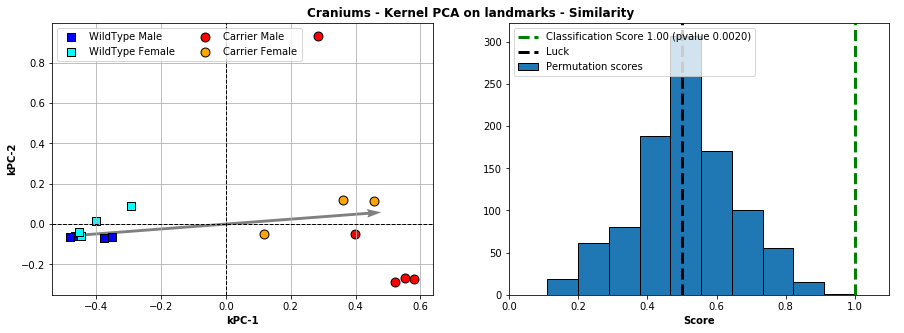

In [7]:
landmarks = l_simil
landmarks = vtk_to_numpy(landmarks)
landmarks = landmarks.reshape(landmarks.shape[0], -1)

%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1 = fig.add_subplot(121)

idx = [0,1]
n_permutations=1000

pca = PCA(n_components=5)
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=5, gamma=.25)
X_kpca = kpca.fit_transform(landmarks)

for i in range(X_kpca.shape[1]):
    df['PC{}'.format(i+1)] = X_kpca[:, i]

ax1.axhline(linewidth=1, color='k', linestyle= '--')
ax1.axvline(linewidth=1, color='k', linestyle= '--')

# for index, label in enumerate(df['id'].values):
#     plt.text(X_kpca[index, idx[0]]+.01, X_kpca[index, idx[1]]+.01, label, color='grey')

ax1.grid(True)
ax1.set_xlabel('kPC-{}'.format(idx[0]+1), fontweight='bold')
ax1.set_ylabel('kPC-{}'.format(idx[1]+1), fontweight='bold')

g1 = df['GroupId'].values < 0
g2 = df['GroupId'].values > 0
mean_g1 = np.array([np.mean(X_kpca[g1, idx]) for idx in range(X_kpca.shape[1])])
mean_g2 = np.array([np.mean(X_kpca[g2, idx]) for idx in range(X_kpca.shape[1])])
separation_vector = mean_g2 - mean_g1
ax1.quiver([0, 0], 
           [0, 0], 
           [ -.5 * separation_vector[idx[0]], .5 * separation_vector[idx[0]]], 
           [ -.5 * separation_vector[idx[1]], .5 * separation_vector[idx[1]]], 
           color='grey',
           scale=1.)
ax1.scatter(X_kpca[WTm, idx[0]], X_kpca[WTm, idx[1]], c="b", s=80, edgecolor='k', marker='s', label='WildType Male')
ax1.scatter(X_kpca[WTf, idx[0]], X_kpca[WTf, idx[1]], c="cyan", s=80, edgecolor='k', marker='s', label='WildType Female')
ax1.scatter(X_kpca[CRm, idx[0]], X_kpca[CRm, idx[1]], c="r", s=80, edgecolor='k', marker='o', label='Carrier Male')
ax1.scatter(X_kpca[CRf, idx[0]], X_kpca[CRf, idx[1]], c="orange", s=80, edgecolor='k', marker='o', label='Carrier Female')
# plt.xlim([0.6,-0.25])

ax1.legend(loc='best', fancybox=True, ncol=2)

ax2 = fig.add_subplot(122)

X = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values
y = np.array((df['GroupId'].values + 1) / 2, dtype=int)

n_classes = np.unique(y).size

# Some noisy data not correlated
random = np.random.RandomState(seed=0)
E = random.normal(size=(len(X), 2200))

svm = SVC(kernel='linear')
cv = StratifiedKFold()

scores = cross_val_score(svm, X, y, cv=cv, scoring="accuracy")

print("SVM Classification score {:.2f} +/- {:.2f})".format(scores.mean(), scores.std()))

score, permutation_scores, pvalue = permutation_test_score(
    svm, X, y, scoring="accuracy", cv=cv, n_permutations=n_permutations, n_jobs=10)

print("Classification score {:.2f} (pvalue : {:.4f})".format(score, pvalue))


# #############################################################################
# View histogram of permutation scores
ax2.hist(permutation_scores, 10, label='Permutation scores',
         edgecolor='black')
ylim = ax2.get_ylim()
ax2.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score {:.2f}'
         ' (pvalue {:.4f})'.format(score, pvalue))
ax2.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

ax2.set_ylim(ylim)
ax2.legend()
ax2.set_xlabel('Score', fontweight='bold')
ax2.set_xlim((0,1.1))

ax.set_title('Craniums - Kernel PCA on landmarks - Similarity', fontweight='bold')
plt.savefig(os.path.join(working_directory, 'craniums-kpca-simil-#1.pdf'))


## Loading momenta

The momenta are stored after atlas creation as text files

In [8]:
working_directory = os.path.join(os.getcwd(), 'data', 'figures', 'craniums', 'atlas-rigid')

controlpoints = np.loadtxt(os.path.join(working_directory, 'Atlas_ControlPoints.txt'))
f = open(os.path.join(working_directory, 'Atlas_Momentas.txt'))
first_line = f.readline().split(' ')
number_of_subjects = int(first_line[0])
number_of_controlpoints_rigid = int(first_line[1])
dimension = int(first_line[2])
f.close()
momenta = np.loadtxt(os.path.join(working_directory, os.path.join(working_directory, 'Atlas_Momentas.txt')), 
                     skiprows=2)
momenta_linearised_rigid = momenta.reshape([number_of_subjects, dimension*number_of_controlpoints_rigid])

working_directory = os.path.join(os.getcwd(), 'data', 'figures', 'craniums', 'atlas-simil')

controlpoints = np.loadtxt(os.path.join(working_directory, 'Atlas_ControlPoints.txt'))
f = open(os.path.join(working_directory, 'Atlas_Momentas.txt'))
first_line = f.readline().split(' ')
number_of_subjects = int(first_line[0])
number_of_controlpoints_simil = int(first_line[1])
dimension = int(first_line[2])
f.close()
momenta = np.loadtxt(os.path.join(working_directory, os.path.join(working_directory, 'Atlas_Momentas.txt')), 
                     skiprows=2)
momenta_linearised_simil = momenta.reshape([number_of_subjects, dimension*number_of_controlpoints_simil])

print('Control Points (rigid/simil): {}/{}'.format(number_of_controlpoints_rigid, number_of_controlpoints_simil))
print('Subjects: {}'.format(number_of_subjects))
print('Dimension: {}'.format(dimension))

working_directory = os.path.join(os.getcwd(), 'data', 'figures', 'craniums')


Control Points (rigid/simil): 1782/1881
Subjects: 16
Dimension: 3


# Kernel PCA on Momenta - Rigid

SVM Classification score 1.00 +/- 0.00)
Classification score 1.00 (pvalue : 0.0020)


<Figure size 504x360 with 0 Axes>

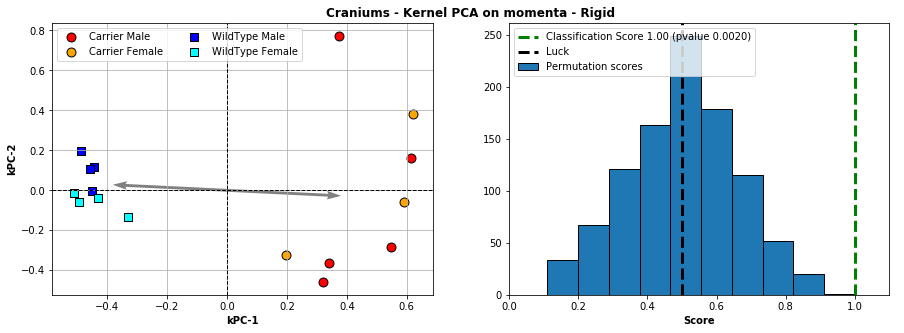

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
fig = plt.figure(figsize=(7,5))
idx = [0,1]

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=5, gamma=.25)
X_kpca = kpca.fit_transform(momenta_linearised_rigid)

for i in range(X_kpca.shape[1]):
    df['PC{}'.format(i+1)] = X_kpca[:, i]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1 = fig.add_subplot(121)

ax1.axhline(linewidth=1, color='k', linestyle= '--')
ax1.axvline(linewidth=1, color='k', linestyle= '--')

# for index, label in enumerate(df['id'].values):
#     plt.text(X_kpca[index, idx[0]]+.01, X_kpca[index, idx[1]]+.01, label, color='grey')

ax1.grid(True)
ax1.set_xlabel('kPC-{}'.format(idx[0]+1), fontweight='bold')
ax1.set_ylabel('kPC-{}'.format(idx[1]+1), fontweight='bold')

g1 = df['GroupId'].values < 0
g2 = df['GroupId'].values > 0
mean_g1 = np.array([np.mean(X_kpca[g1, idx]) for idx in range(X_kpca.shape[1])])
mean_g2 = np.array([np.mean(X_kpca[g2, idx]) for idx in range(X_kpca.shape[1])])
separation_vector = mean_g2 - mean_g1
ax1.quiver([0, 0], 
           [0, 0], 
           [ -.5 * separation_vector[idx[0]], .5 * separation_vector[idx[0]]], 
           [ -.5 * separation_vector[idx[1]], .5 * separation_vector[idx[1]]], 
           color='grey',
           scale=1.5)
ax1.scatter(X_kpca[CRm, idx[0]], X_kpca[CRm, idx[1]], c="r", s=80, edgecolor='k', marker='o', label='Carrier Male')
ax1.scatter(X_kpca[CRf, idx[0]], X_kpca[CRf, idx[1]], c="orange", s=80, edgecolor='k', marker='o', label='Carrier Female')
ax1.scatter(X_kpca[WTm, idx[0]], X_kpca[WTm, idx[1]], c="b", s=80, edgecolor='k', marker='s', label='WildType Male')
ax1.scatter(X_kpca[WTf, idx[0]], X_kpca[WTf, idx[1]], c="cyan", s=80, edgecolor='k', marker='s', label='WildType Female')
# plt.xlim([0.6,-0.25])

ax1.legend(loc='best', fancybox=True, ncol=2)

ax2 = fig.add_subplot(122)

X = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values
y = np.array((df['GroupId'].values + 1) / 2, dtype=int)

n_classes = np.unique(y).size

# Some noisy data not correlated
random = np.random.RandomState(seed=0)
E = random.normal(size=(len(X), 2200))

svm = SVC(kernel='linear')
cv = StratifiedKFold()

scores = cross_val_score(svm, X, y, cv=cv, scoring="accuracy")

print("SVM Classification score {:.2f} +/- {:.2f})".format(scores.mean(), scores.std()))

score, permutation_scores, pvalue = permutation_test_score(
    svm, X, y, scoring="accuracy", cv=cv, n_permutations=n_permutations, n_jobs=10)

print("Classification score {:.2f} (pvalue : {:.4f})".format(score, pvalue))


# #############################################################################
# View histogram of permutation scores
ax2.hist(permutation_scores, 10, label='Permutation scores',
         edgecolor='black')
ylim = ax2.get_ylim()
ax2.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score {:.2f}'
         ' (pvalue {:.4f})'.format(score, pvalue))
ax2.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

ax2.set_ylim(ylim)
ax2.legend()
ax2.set_xlabel('Score', fontweight='bold')
ax2.set_xlim((0,1.1))

ax.set_title('Craniums - Kernel PCA on momenta - Rigid', fontweight='bold')
plt.savefig(os.path.join(working_directory, 'craniums-kpca-rigid-#2.pdf'))


# Kernel PCA on Momenta - Simil

SVM Classification score 0.94 +/- 0.08)
Classification score 0.94 (pvalue : 0.0020)


<Figure size 504x360 with 0 Axes>

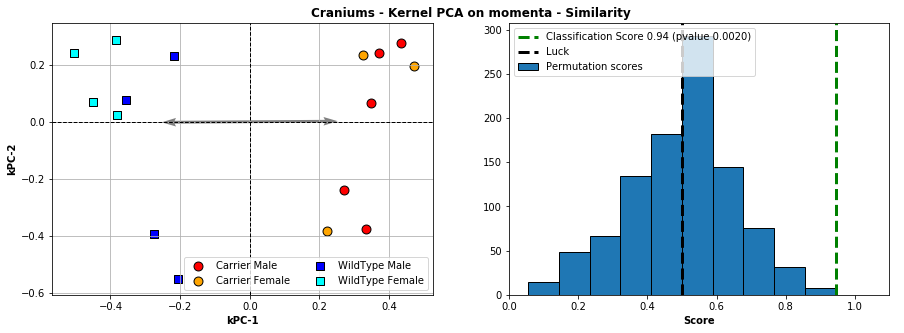

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
fig = plt.figure(figsize=(7,5))
idx = [0,1]

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=5, gamma=.25)
X_kpca = kpca.fit_transform(momenta_linearised_simil)

for i in range(X_kpca.shape[1]):
    df['PC{}'.format(i+1)] = X_kpca[:, i]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1 = fig.add_subplot(121)

ax1.axhline(linewidth=1, color='k', linestyle= '--')
ax1.axvline(linewidth=1, color='k', linestyle= '--')

# for index, label in enumerate(df['id'].values):
#     plt.text(X_kpca[index, idx[0]]+.01, X_kpca[index, idx[1]]+.01, label, color='grey')

ax1.grid(True)
ax1.set_xlabel('kPC-{}'.format(idx[0]+1), fontweight='bold')
ax1.set_ylabel('kPC-{}'.format(idx[1]+1), fontweight='bold')

g1 = df['GroupId'].values < 0
g2 = df['GroupId'].values > 0
mean_g1 = np.array([np.mean(X_kpca[g1, idx]) for idx in range(X_kpca.shape[1])])
mean_g2 = np.array([np.mean(X_kpca[g2, idx]) for idx in range(X_kpca.shape[1])])
separation_vector = mean_g2 - mean_g1
ax1.quiver([0, 0], 
           [0, 0], 
           [ -.5 * separation_vector[idx[0]], .5 * separation_vector[idx[0]]], 
           [ -.5 * separation_vector[idx[1]], .5 * separation_vector[idx[1]]], 
           color='grey',
           scale=1.5)
ax1.scatter(X_kpca[CRm, idx[0]], X_kpca[CRm, idx[1]], c="r", s=80, edgecolor='k', marker='o', label='Carrier Male')
ax1.scatter(X_kpca[CRf, idx[0]], X_kpca[CRf, idx[1]], c="orange", s=80, edgecolor='k', marker='o', label='Carrier Female')
ax1.scatter(X_kpca[WTm, idx[0]], X_kpca[WTm, idx[1]], c="b", s=80, edgecolor='k', marker='s', label='WildType Male')
ax1.scatter(X_kpca[WTf, idx[0]], X_kpca[WTf, idx[1]], c="cyan", s=80, edgecolor='k', marker='s', label='WildType Female')
# plt.xlim([0.6,-0.25])

ax1.legend(loc='best', fancybox=True, ncol=2)

ax2 = fig.add_subplot(122)

X = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values
y = np.array((df['GroupId'].values + 1) / 2, dtype=int)

n_classes = np.unique(y).size

# Some noisy data not correlated
random = np.random.RandomState(seed=0)
E = random.normal(size=(len(X), 2200))

svm = SVC(kernel='linear')
cv = StratifiedKFold()

scores = cross_val_score(svm, X, y, cv=cv, scoring="accuracy")

print("SVM Classification score {:.2f} +/- {:.2f})".format(scores.mean(), scores.std()))

score, permutation_scores, pvalue = permutation_test_score(
    svm, X, y, scoring="accuracy", cv=cv, n_permutations=n_permutations, n_jobs=10)

print("Classification score {:.2f} (pvalue : {:.4f})".format(score, pvalue))


# #############################################################################
# View histogram of permutation scores
ax2.hist(permutation_scores, 10, label='Permutation scores',
         edgecolor='black')
ylim = ax2.get_ylim()
ax2.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score {:.2f}'
         ' (pvalue {:.4f})'.format(score, pvalue))
ax2.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

ax2.set_ylim(ylim)
ax2.legend()
ax2.set_xlabel('Score', fontweight='bold')
ax2.set_xlim((0,1.1))

ax.set_title('Craniums - Kernel PCA on momenta - Similarity', fontweight='bold')
plt.savefig(os.path.join(working_directory, 'craniums-kpca-simil-#2.pdf'))


## Shooting and heat maps - methods

In [11]:

def compute_cell_surfaces(polydata):
    pt_ids = vtk.vtkIdList()
    tr = vtk.vtkTriangle()
    areas = vtk.vtkFloatArray()
    areas.SetNumberOfComponents(1)
    areas.SetNumberOfTuples(polydata.GetNumberOfPolys())
    areas.SetName('Area')

    for idx in range(polydata.GetNumberOfPolys()):
        polydata.GetCellPoints(idx, pt_ids)
        pts = []
        for pt_ids_id in range(pt_ids.GetNumberOfIds()):
            pts.append(polydata.GetPoint(pt_ids.GetId(pt_ids_id)))
        assert(len(pts) == 3)
        v = tr.TriangleArea(pts[0], pts[1], pts[2])
        areas.SetTuple1(idx, v)

    polydata.GetCellData().SetScalars(areas)

def compute_cell_surfaces_differences(in1, in2, out):
    pt_ids = vtk.vtkIdList()
    tr = vtk.vtkTriangle()
    areas = vtk.vtkFloatArray()
    areas.SetNumberOfComponents(1)
    areas.SetNumberOfTuples(in1.GetNumberOfPolys())
    areas.SetName('Volume Change (in %)')

    for idx in range(in1.GetNumberOfPolys()):
        in1.GetCellPoints(idx, pt_ids)
        pts = []
        for pt_ids_id in range(pt_ids.GetNumberOfIds()):
            pts.append(in1.GetPoint(pt_ids.GetId(pt_ids_id)))
        assert(len(pts) == 3)
        v1 = tr.TriangleArea(pts[0], pts[1], pts[2])
        in2.GetCellPoints(idx, pt_ids)
        pts = []
        for pt_ids_id in range(pt_ids.GetNumberOfIds()):
            pts.append(in2.GetPoint(pt_ids.GetId(pt_ids_id)))
        assert(len(pts) == 3)
        v2 = tr.TriangleArea(pts[0], pts[1], pts[2])
        areas.SetTuple1(idx, 100. * 2. * (v1-v2) / (v1+v2))

    out.GetCellData().SetScalars(areas)


def compute_absolute_cell_surfaces_differences(in1, in2, out):
    pt_ids = vtk.vtkIdList()
    tr = vtk.vtkTriangle()
    areas = vtk.vtkFloatArray()
    areas.SetNumberOfComponents(1)
    areas.SetNumberOfTuples(in1.GetNumberOfPolys())
    areas.SetName('Absolute Volume Change (in %)')

    for idx in range(in1.GetNumberOfPolys()):
        in1.GetCellPoints(idx, pt_ids)
        pts = []
        for pt_ids_id in range(pt_ids.GetNumberOfIds()):
            pts.append(in1.GetPoint(pt_ids.GetId(pt_ids_id)))
        assert(len(pts) == 3)
        v1 = tr.TriangleArea(pts[0], pts[1], pts[2])
        in2.GetCellPoints(idx, pt_ids)
        pts = []
        for pt_ids_id in range(pt_ids.GetNumberOfIds()):
            pts.append(in2.GetPoint(pt_ids.GetId(pt_ids_id)))
        assert(len(pts) == 3)
        v2 = tr.TriangleArea(pts[0], pts[1], pts[2])
        areas.SetTuple1(idx, 100. * 2. * np.abs(v1-v2) / (v1+v2))

    out.GetCellData().SetScalars(areas)
    
def compute_cell_volume_differences(in1, in2, out):
    pt_ids = vtk.vtkIdList()
    tr = vtk.vtkTetra()
    areas = vtk.vtkFloatArray()
    areas.SetNumberOfComponents(1)
    areas.SetNumberOfTuples(in1.GetNumberOfCells())
    areas.SetName('Volume Change (in %) - True')

    for idx in range(in1.GetNumberOfCells()):
        in1.GetCellPoints(idx, pt_ids)
        pts = []
        for pt_ids_id in range(pt_ids.GetNumberOfIds()):
            pts.append(in1.GetPoint(pt_ids.GetId(pt_ids_id)))
        if(len(pts) != 4):
            continue
        
        v1 = tr.ComputeVolume(pts[0], pts[1], pts[2], pts[3])
        in2.GetCellPoints(idx, pt_ids)
        pts = []
        for pt_ids_id in range(pt_ids.GetNumberOfIds()):
            pts.append(in2.GetPoint(pt_ids.GetId(pt_ids_id)))
        assert(len(pts) == 4)
        v2 = tr.ComputeVolume(pts[0], pts[1], pts[2], pts[3])
        areas.SetTuple1(idx, 100. * 2. * (v1-v2) / (v1+v2))

    out.GetCellData().SetScalars(areas)


def compute_point_displacements(in1, in2, out):
    displacements = vtk.vtkFloatArray()
    displacements.SetNumberOfComponents(1)
    displacements.SetNumberOfTuples(in1.GetNumberOfPoints())
    displacements.SetName('Displacements (in mm)')

    for idx in range(in1.GetNumberOfPoints()):
        pt1 = in1.GetPoint(idx)
        pt2 = in2.GetPoint(idx)
        displacements.SetTuple1(idx, np.sqrt(vtk.vtkMath.Distance2BetweenPoints(pt1, pt2)))

    out.GetPointData().SetScalars(displacements)



def cyclic_combination(forward_files, backward_files, destination):
    import shutil
    import os
    assert(len(forward_files) == len(backward_files))
    N = 4 * len(forward_files)
    combined_list = list(reversed(backward_files))
    combined_list.extend(forward_files)
    combined_list.extend(list(reversed(forward_files)))
    combined_list.extend(backward_files)

    for idx, f in enumerate(combined_list):
        dest = os.path.join(destination, 'separation_{:03d}.vtk'.format(idx))
        shutil.copy(f, dest)

## Shooting

In [12]:
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=5, gamma=.25)
X_kpca = kpca.fit_transform(momenta_linearised_rigid)
g1 = df['GroupId'].values < 0
g2 = df['GroupId'].values > 0
mean_g1 = np.array([np.mean(X_kpca[g1, idx]) for idx in range(X_kpca.shape[1])])
mean_g2 = np.array([np.mean(X_kpca[g2, idx]) for idx in range(X_kpca.shape[1])])
separation_vector = mean_g2 - mean_g1

eigenvalues = kpca.lambdas_
eigenvectors = kpca.alphas_ / np.linalg.norm(kpca.alphas_, axis=0)

shooting_directory = os.path.join(working_directory, 'atlas-rigid', 'shooting')

projection = np.matmul(eigenvectors.transpose(), momenta_linearised_rigid)
shoot = np.matmul(separation_vector, projection)
shoot = shoot.reshape(number_of_controlpoints_rigid, dimension)

forward_shoot = .5 * shoot
backward_shoot = -.5 * shoot

np.savetxt(os.path.join(shooting_directory, 'forward.txt'),   forward_shoot)
np.savetxt(os.path.join(shooting_directory, 'backward.txt'), backward_shoot)

# workaround for the backward bug
if backward_shoot[0,0] < 0:
    backward_shoot[0,0] = 0.
np.savetxt(os.path.join(shooting_directory, 'backward.txt'), backward_shoot)

import os

script_filename = os.path.join(shooting_directory, 'shooting.sh')

## create directories where forward and backward temporary shapes will be stored
if not os.path.exists(os.path.join(shooting_directory, 'backward')):
    os.mkdir(os.path.join(shooting_directory, 'backward'))
if not os.path.exists(os.path.join(shooting_directory, 'forward')):
    os.mkdir(os.path.join(shooting_directory, 'forward'))

## execute the shooting
os.system('bash {}'.format(script_filename))

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=5, gamma=.25)
X_kpca = kpca.fit_transform(momenta_linearised_simil)
g1 = df['GroupId'].values < 0
g2 = df['GroupId'].values > 0
mean_g1 = np.array([np.mean(X_kpca[g1, idx]) for idx in range(X_kpca.shape[1])])
mean_g2 = np.array([np.mean(X_kpca[g2, idx]) for idx in range(X_kpca.shape[1])])
separation_vector = mean_g2 - mean_g1

eigenvalues = kpca.lambdas_
eigenvectors = kpca.alphas_ / np.linalg.norm(kpca.alphas_, axis=0)

shooting_directory = os.path.join(working_directory, 'atlas-simil', 'shooting')

projection = np.matmul(eigenvectors.transpose(), momenta_linearised_simil)
shoot = np.matmul(separation_vector, projection)
shoot = shoot.reshape(number_of_controlpoints_simil, dimension)

forward_shoot = .5 * shoot
backward_shoot = -.5 * shoot

np.savetxt(os.path.join(shooting_directory, 'forward.txt'),   forward_shoot)
np.savetxt(os.path.join(shooting_directory, 'backward.txt'), backward_shoot)

# workaround for the backward bug
if backward_shoot[0,0] < 0:
    backward_shoot[0,0] = 0.
np.savetxt(os.path.join(shooting_directory, 'backward.txt'), backward_shoot)

import os

script_filename = os.path.join(shooting_directory, 'shooting.sh')

## create directories where forward and backward temporary shapes will be stored
if not os.path.exists(os.path.join(shooting_directory, 'backward')):
    os.mkdir(os.path.join(shooting_directory, 'backward'))
if not os.path.exists(os.path.join(shooting_directory, 'forward')):
    os.mkdir(os.path.join(shooting_directory, 'forward'))

## execute the shooting
os.system('bash {}'.format(script_filename))


0

## Heatmaps - Rigid

In [13]:
shooting_directory = os.path.join(working_directory, 'atlas-rigid', 'shooting')

meshfiles1 = glob('{}/forward/*.vtk'.format(shooting_directory))
meshfiles2 = glob('{}/backward/*.vtk'.format(shooting_directory))

meshfiles1.sort()
meshfiles2.sort()

list_order = [' '] * len(meshfiles1)
for f in meshfiles1:
    idx = int(f[(f.index('t_')+len('t_')):f.index('.vtk')])
    list_order[idx] = f
meshfiles1 = list_order

list_order = [' '] * len(meshfiles2)
for f in meshfiles2:
    idx = int(f[(f.index('t_')+len('t_')):f.index('.vtk')])
    list_order[idx] = f
meshfiles2 = list_order

shooting_df = pd.DataFrame()

shooting_df['backward'] = [os.path.basename(meshfiles2[idx]) for idx in range(len(meshfiles2))]
shooting_df['forward']  = [os.path.basename(meshfiles1[idx]) for idx in range(len(meshfiles1))]


if not os.path.exists(os.path.join(shooting_directory, 'combined')):
    os.mkdir(os.path.join(shooting_directory, 'combined'))

cyclic_combination(meshfiles1, meshfiles2, 
                   os.path.join(shooting_directory, 'combined'))

meshfile_c = '{}/backward/Atlas_initial_template_flow__t_19.vtk'.format(shooting_directory)

reader = vtk.vtkPolyDataReader()
reader.SetFileName(meshfile_c)
reader.Update()
mean = reader.GetOutput()

meshes = meshfiles1+meshfiles2

for idx, mfile in enumerate(meshes):
    ### read mesh
    reader1 = vtk.vtkPolyDataReader()
    reader1.SetFileName(mfile)
    reader1.Update()
    m = reader1.GetOutput()

    compute_point_displacements(m, mean, m)
    compute_cell_surfaces_differences(m, mean, m)
#     compute_absolute_cell_surfaces_differences(m, mean, m)
    ### write mesh
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(m)
    writer.SetFileName(mfile)    
    writer.Update()

cyclic_combination(meshfiles1, meshfiles2, os.path.join(shooting_directory, 'combined'))

## Heatmaps - Similarity

In [14]:
shooting_directory = os.path.join(working_directory, 'atlas-simil', 'shooting')

meshfiles1 = glob('{}/forward/*.vtk'.format(shooting_directory))
meshfiles2 = glob('{}/backward/*.vtk'.format(shooting_directory))

meshfiles1.sort()
meshfiles2.sort()

list_order = [' '] * len(meshfiles1)
for f in meshfiles1:
    idx = int(f[(f.index('t_')+len('t_')):f.index('.vtk')])
    list_order[idx] = f
meshfiles1 = list_order

list_order = [' '] * len(meshfiles2)
for f in meshfiles2:
    idx = int(f[(f.index('t_')+len('t_')):f.index('.vtk')])
    list_order[idx] = f
meshfiles2 = list_order

shooting_df = pd.DataFrame()

shooting_df['backward'] = [os.path.basename(meshfiles2[idx]) for idx in range(len(meshfiles2))]
shooting_df['forward']  = [os.path.basename(meshfiles1[idx]) for idx in range(len(meshfiles1))]


if not os.path.exists(os.path.join(shooting_directory, 'combined')):
    os.mkdir(os.path.join(shooting_directory, 'combined'))

cyclic_combination(meshfiles1, meshfiles2, 
                   os.path.join(shooting_directory, 'combined'))

meshfile_c = '{}/backward/Atlas_initial_template_flow__t_19.vtk'.format(shooting_directory)

reader = vtk.vtkPolyDataReader()
reader.SetFileName(meshfile_c)
reader.Update()
mean = reader.GetOutput()

meshes = meshfiles1+meshfiles2

for idx, mfile in enumerate(meshes):
    ### read mesh
    reader1 = vtk.vtkPolyDataReader()
    reader1.SetFileName(mfile)
    reader1.Update()
    m = reader1.GetOutput()

    compute_point_displacements(m, mean, m)
    compute_cell_surfaces_differences(m, mean, m)
#     compute_absolute_cell_surfaces_differences(m, mean, m)
    ### write mesh
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(m)
    writer.SetFileName(mfile)    
    writer.Update()

cyclic_combination(meshfiles1, meshfiles2, os.path.join(shooting_directory, 'combined'))

## About this notebook

written by Nicolas Toussaint

Contact: <nicolas.a.toussaint@kcl.ac.uk>